<h2>COMPARING NEIGHBORHOODS OF TORONTO AND NEWYORK CITIES</h2>

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

<h2>Loading and Preparing the Neighborhoods Data for Toronto City</h2>

In [3]:
excel_file='TorontoGeo.xlsx'
df=pd.read_excel(excel_file,sheet_name='Toronto')
df.shape

(180, 3)

<h4>Ignoring cells with a borough that is Not assigned</h4>

In [4]:
df=df[df['Borough']!='Not assigned']

In [5]:
df.shape

(103, 3)

<h3>Load Coordinates data into a pandas dataframe</h3>

In [6]:
df_cord=pd.read_csv('Geospatial_Coordinates.csv')
df_cord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
df_cord.shape

(103, 3)

<h4> Dataframe with geographical coordinates of each postal code</h4>

In [10]:
tor_neighborhoods= pd.merge(df, df_cord, on='Postal Code')
tor_neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


<h4>Get the latitude and longitude values of Toronto City.</h4>

In [147]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


<h4>Map of Toronto City with neighborhoods superimposed on top</h4>

In [148]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tor_neighborhoods['Latitude'], tor_neighborhoods['Longitude'], tor_neighborhoods['Borough'], tor_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [29]:
CLIENT_ID = 'WFSO5NY5PKYOKEKLO14024JIOU11YBEYDAJBBUD513TG0ZT0' # your Foursquare ID
CLIENT_SECRET = '3RDVT1ZS35LMBH5JOXVOWEFMPW33NANKVSN2OMUOLXG2F2S3' # your Foursquare Secret
VERSION = '20200514'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WFSO5NY5PKYOKEKLO14024JIOU11YBEYDAJBBUD513TG0ZT0
CLIENT_SECRET:3RDVT1ZS35LMBH5JOXVOWEFMPW33NANKVSN2OMUOLXG2F2S3


<h3>Explore all Neighborhoods in Toronto</h3>

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3>Retrieving Venue Data for Toronto</h3>

In [31]:
tor_venues = getNearbyVenues(names=tor_neighborhoods['Neighborhood'],
                             latitudes=tor_neighborhoods['Latitude'],
                             longitudes=tor_neighborhoods['Longitude']
                            )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [32]:
print(tor_venues.shape)
tor_venues.head()

(1325, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [33]:
# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(1318, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [34]:
tor_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                                                                                                                  5
Alderwood, Long Branch                                                                                                                     9
Bathurst Manor, Wilson Heights, Downsview North                                                                                           20
Bayview Village                                                                                                                            4
Bedford Park, Lawrence Manor East                                                                                                         23
Berczy Park                                                                                                                               30
Birch Cliff, Cliffside West                                                                                                                4


In [35]:
tor_neighborhoods.shape[0], tor_venues['Neighborhood'].unique().shape[0]

(103, 94)

In [36]:
tor_excluded_neighborhoods = set(tor_neighborhoods['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

{'Islington Avenue',
 'Upper Rouge',
 'Willowdale, Newtonbrook',
 'York Mills, Silver Hills'}

In [37]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 226 uniques categories.


<h4>Analyze each Neighborhood</h4>

In [38]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Neighborhood_,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [39]:
tor_onehot.shape

(1318, 227)

<h4>Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category</h4>

In [40]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

,Neighborhood_,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0

In [41]:
tor_grouped.shape

(94, 227)

In [42]:
#function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<h4> Top 10 venue for each neighborhood</h4>

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_venues_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

tor_neighborhoods_venues_sorted.head()

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Clothing Store,Skating Rink,Yoga Studio,Distribution Center,Farmers Market,Falafel Restaurant,Event Space
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pharmacy,Coffee Shop,Pool,Pub,Sandwich Place,Gym,American Restaurant,Dim Sum Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Frozen Yogurt Shop,Shopping Mall,Sandwich Place,Diner,Supermarket,Restaurant,Sushi Restaurant
3,Bayview Village,Bank,Café,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Distribution Center,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Liquor Store,Juice Bar,Sushi Restaurant,Restaurant,Pub,Hobby Shop,Thai Restaurant


<h2>Cluster Neighborhoods</h2>

<h4>Cluster the neighborhood into 5 clusters.</h4>

In [44]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

<h4>New dataframe that includes the cluster as well as the top 10 venues for each neighborhood</h4>

In [47]:
# add clustering labels
tor_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_venues_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head()

,Postal Code,Borough,Neighborhood_,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,Construction & Landscaping,Park,Food & Drink Shop,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Pizza Place,Portuguese Restaurant,Coffee Shop,Hockey Arena,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Theater,Breakfast Spot,Café,French Restaurant,Spa,Event Space,Yoga Studio
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Accessories Store,Coffee Shop,Event Space,Miscellaneous Shop,Furniture / Home Store,Boutique,Vietnamese Restaurant,Cuban Restaurant,Distribution Center
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Theater,Sandwich Place,Café,Juice Bar,Japanese Restaurant,Italian Restaurant,Beer Bar


<h4>Visualize the resulting clusters</h4>

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood_'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Examine Clusters</h2>

<h3>Cluster 1</h3>

In [52]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]].head(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Pizza Place,Portuguese Restaurant,Coffee Shop,Hockey Arena,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
2,Downtown Toronto,0,Coffee Shop,Park,Bakery,Theater,Breakfast Spot,Café,French Restaurant,Spa,Event Space,Yoga Studio


<h3>Cluster 2</h3>

In [53]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]].head(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,1,Playground,Comfort Food Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop
85,Scarborough,1,Playground,Park,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop


<h3>Cluster 3</h3>

In [54]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]].head(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,2,Baseball Field,Furniture / Home Store,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
101,Etobicoke,2,Baseball Field,Yoga Studio,Discount Store,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant


<h3>Cluster 4</h3>

In [55]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]].head(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3,Construction & Landscaping,Park,Food & Drink Shop,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
10,North York,3,Park,Pub,Japanese Restaurant,Asian Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Electronics Store


<h3>Cluster 5</h3>

In [56]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]].head(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Etobicoke,4,Home Service,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore


<h2>Loading and Preparing the Neighborhoods Data for New York City</h2>

In [58]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [59]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

<h3>Transform Json data into Dataframe</h3>

In [61]:
nyc_neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)

In [62]:
nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [63]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<h4>There are neighborhoods that share the same name but are located in different boroughs as shown below:</h4>

In [64]:
nnvc = nyc_neighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Bay Terrace    2
Chelsea        2
Murray Hill    2
Sunnyside      2
Name: Neighborhood, dtype: int64

In [65]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == 'Murray Hill']

,Borough,Neighborhood,Latitude,Longitude
115,Manhattan,Murray Hill,40.748303,-73.978332
180,Queens,Murray Hill,40.764126,-73.812763


<h4>To deal with this case, we will include the borough name in the name of these neighborhoods</h4>

In [66]:
for i in range(nyc_neighborhoods.shape[0]):
    nyn_ = nyc_neighborhoods.loc[i, 'Neighborhood']
    if nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = nyc_neighborhoods.loc[j, 'Borough']
            nyc_neighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [68]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'].str.startswith('Murray Hill')]

,Borough,Neighborhood,Latitude,Longitude
115,Manhattan,"Murray Hill, Manhattan",40.748303,-73.978332
180,Queens,"Murray Hill, Queens",40.764126,-73.812763


<h4>Using geopy Library to get the Coordinates of New York City</h4>

In [69]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


<h4>Creating a Map of New York City with neighborhoods Superimposed on Top</h4>

In [70]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10, 
                         min_zoom=9, max_zoom=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['Borough'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#ffb300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<h4>Venue Data For New York City</h4>

In [72]:
nyc_venues = getNearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                             latitudes=nyc_neighborhoods['Latitude'],
                             longitudes=nyc_neighborhoods['Longitude']
                            )
nyc_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [73]:
# Removing records where venue is "building" or "office"
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(nyc_venues.shape)
nyc_venues.head()

(5988, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [75]:
nyc_neighborhoods.shape[0], nyc_venues['Neighborhood'].unique().shape[0]

(306, 306)

In [76]:
nyc_excluded_neighborhoods = set(nyc_neighborhoods['Neighborhood']).difference(nyc_venues['Neighborhood'])
nyc_excluded_neighborhoods

set()

In [77]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 379 uniques categories.


<h4>Performing one-hot on the venue category</h4>

In [78]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
nyc_onehot['Neighborhood_'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool 

In [79]:
nyc_grouped = nyc_onehot.groupby('Neighborhood_').mean().reset_index()
nyc_grouped.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool 

<h4>Most Common Venues for each neighborhood</h4>

In [82]:
num_top_cat = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = nyc_grouped['Neighborhood_']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Spa,Deli / Bodega,Supermarket,Chinese Restaurant,Intersection,Grocery Store,Bike Trail,Breakfast Spot,Gas Station
1,Annadale,Pizza Place,Park,Pub,Dance Studio,Diner,Liquor Store,American Restaurant,Sports Bar,Train Station,Restaurant
2,Arden Heights,Deli / Bodega,Lawyer,Coffee Shop,Pizza Place,Pharmacy,Distillery,Flea Market,Falafel Restaurant,Farm,Farmers Market
3,Arlington,Deli / Bodega,Coffee Shop,American Restaurant,Liquor Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
4,Arrochar,Deli / Bodega,Italian Restaurant,Pizza Place,Bagel Shop,Liquor Store,Outdoors & Recreation,Mediterranean Restaurant,Athletics & Sports,Middle Eastern Restaurant,Hotel


In [86]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = nyc_grouped['Neighborhood_']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Spa,Deli / Bodega,Supermarket,Chinese Restaurant,Intersection,Grocery Store,Bike Trail,Breakfast Spot,Gas Station
1,Annadale,Pizza Place,Park,Pub,Dance Studio,Diner,Liquor Store,American Restaurant,Sports Bar,Train Station,Restaurant
2,Arden Heights,Deli / Bodega,Lawyer,Coffee Shop,Pizza Place,Pharmacy,Distillery,Flea Market,Falafel Restaurant,Farm,Farmers Market
3,Arlington,Deli / Bodega,Coffee Shop,American Restaurant,Liquor Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
4,Arrochar,Deli / Bodega,Italian Restaurant,Pizza Place,Bagel Shop,Liquor Store,Outdoors & Recreation,Mediterranean Restaurant,Athletics & Sports,Middle Eastern Restaurant,Hotel


<h2>Cluster Neighborhoods</h2>

In [84]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 2, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [93]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
nyc_merged = nyc_merged[~nyc_merged['Neighborhood_'].isin(nyc_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood_,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3,Pharmacy,Gas Station,Sandwich Place,Donut Shop,Ice Cream Shop,Laundromat,Dessert Shop,Deli / Bodega,Flea Market,Falafel Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,3,Baseball Field,Restaurant,Fast Food Restaurant,Gift Shop,Park,Grocery Store,Pharmacy,Trail,Bagel Shop,Liquor Store
2,Bronx,Eastchester,40.887556,-73.827806,3,Caribbean Restaurant,Deli / Bodega,Diner,Platform,Donut Shop,Seafood Restaurant,Fast Food Restaurant,Automotive Shop,Pizza Place,Bowling Alley
3,Bronx,Fieldston,40.895437,-73.905643,1,River,Plaza,Yoga Studio,Fish Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
4,Bronx,Riverdale,40.890834,-73.912585,0,Park,Baseball Field,Medical Supply Store,Bank,Gym,Plaza,Fish Market,Farm,Farmers Market,Fast Food Restaurant


<h3>Visualize clusters</h3>

In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood_'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Examine Clusters</h2>

<h3>Cluster 1</h3>

In [96]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0,nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]].head(2)

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,Park,Baseball Field,Medical Supply Store,Bank,Gym,Plaza,Fish Market,Farm,Farmers Market,Fast Food Restaurant
27,Clason Point,Park,South American Restaurant,Business Service,Pool,Boat or Ferry,Grocery Store,Yoga Studio,Farm,Farmers Market,Fast Food Restaurant


<h3>Cluster 2</h3>

In [97]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1,nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]].head(2)

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,River,Plaza,Yoga Studio,Fish Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
7,Woodlawn,Pub,Deli / Bodega,Bar,Playground,Pizza Place,Park,Cosmetics Shop,Liquor Store,Trail,Food Truck


<h3>Cluster 3</h3>

In [98]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2,nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]].head(2)

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Van Nest,Pizza Place,Deli / Bodega,Middle Eastern Restaurant,Board Shop,Hookah Bar,Playground,Donut Shop,Supermarket,Chinese Restaurant,Discount Store
34,Belmont,Italian Restaurant,Bakery,Deli / Bodega,Pizza Place,Dessert Shop,Food & Drink Shop,Liquor Store,Mexican Restaurant,Market,Bar


<h3>Cluster 4</h3>

In [99]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3,nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]].head(2)

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Gas Station,Sandwich Place,Donut Shop,Ice Cream Shop,Laundromat,Dessert Shop,Deli / Bodega,Flea Market,Falafel Restaurant
1,Co-op City,Baseball Field,Restaurant,Fast Food Restaurant,Gift Shop,Park,Grocery Store,Pharmacy,Trail,Bagel Shop,Liquor Store


<h3>Cluster 5</h3>

In [101]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4,nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]].head(2)

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,Breezy Point,Beach,Trail,Monument / Landmark,Yoga Studio,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
179,Neponsit,Beach,Lounge,Yoga Studio,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


<h2>EXPLORATORY DATA ANALYSIS</h2>

In [103]:
import matplotlib.pyplot as plt

In [104]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

<h3>Most Common Venue Categories in Toronto</h3>

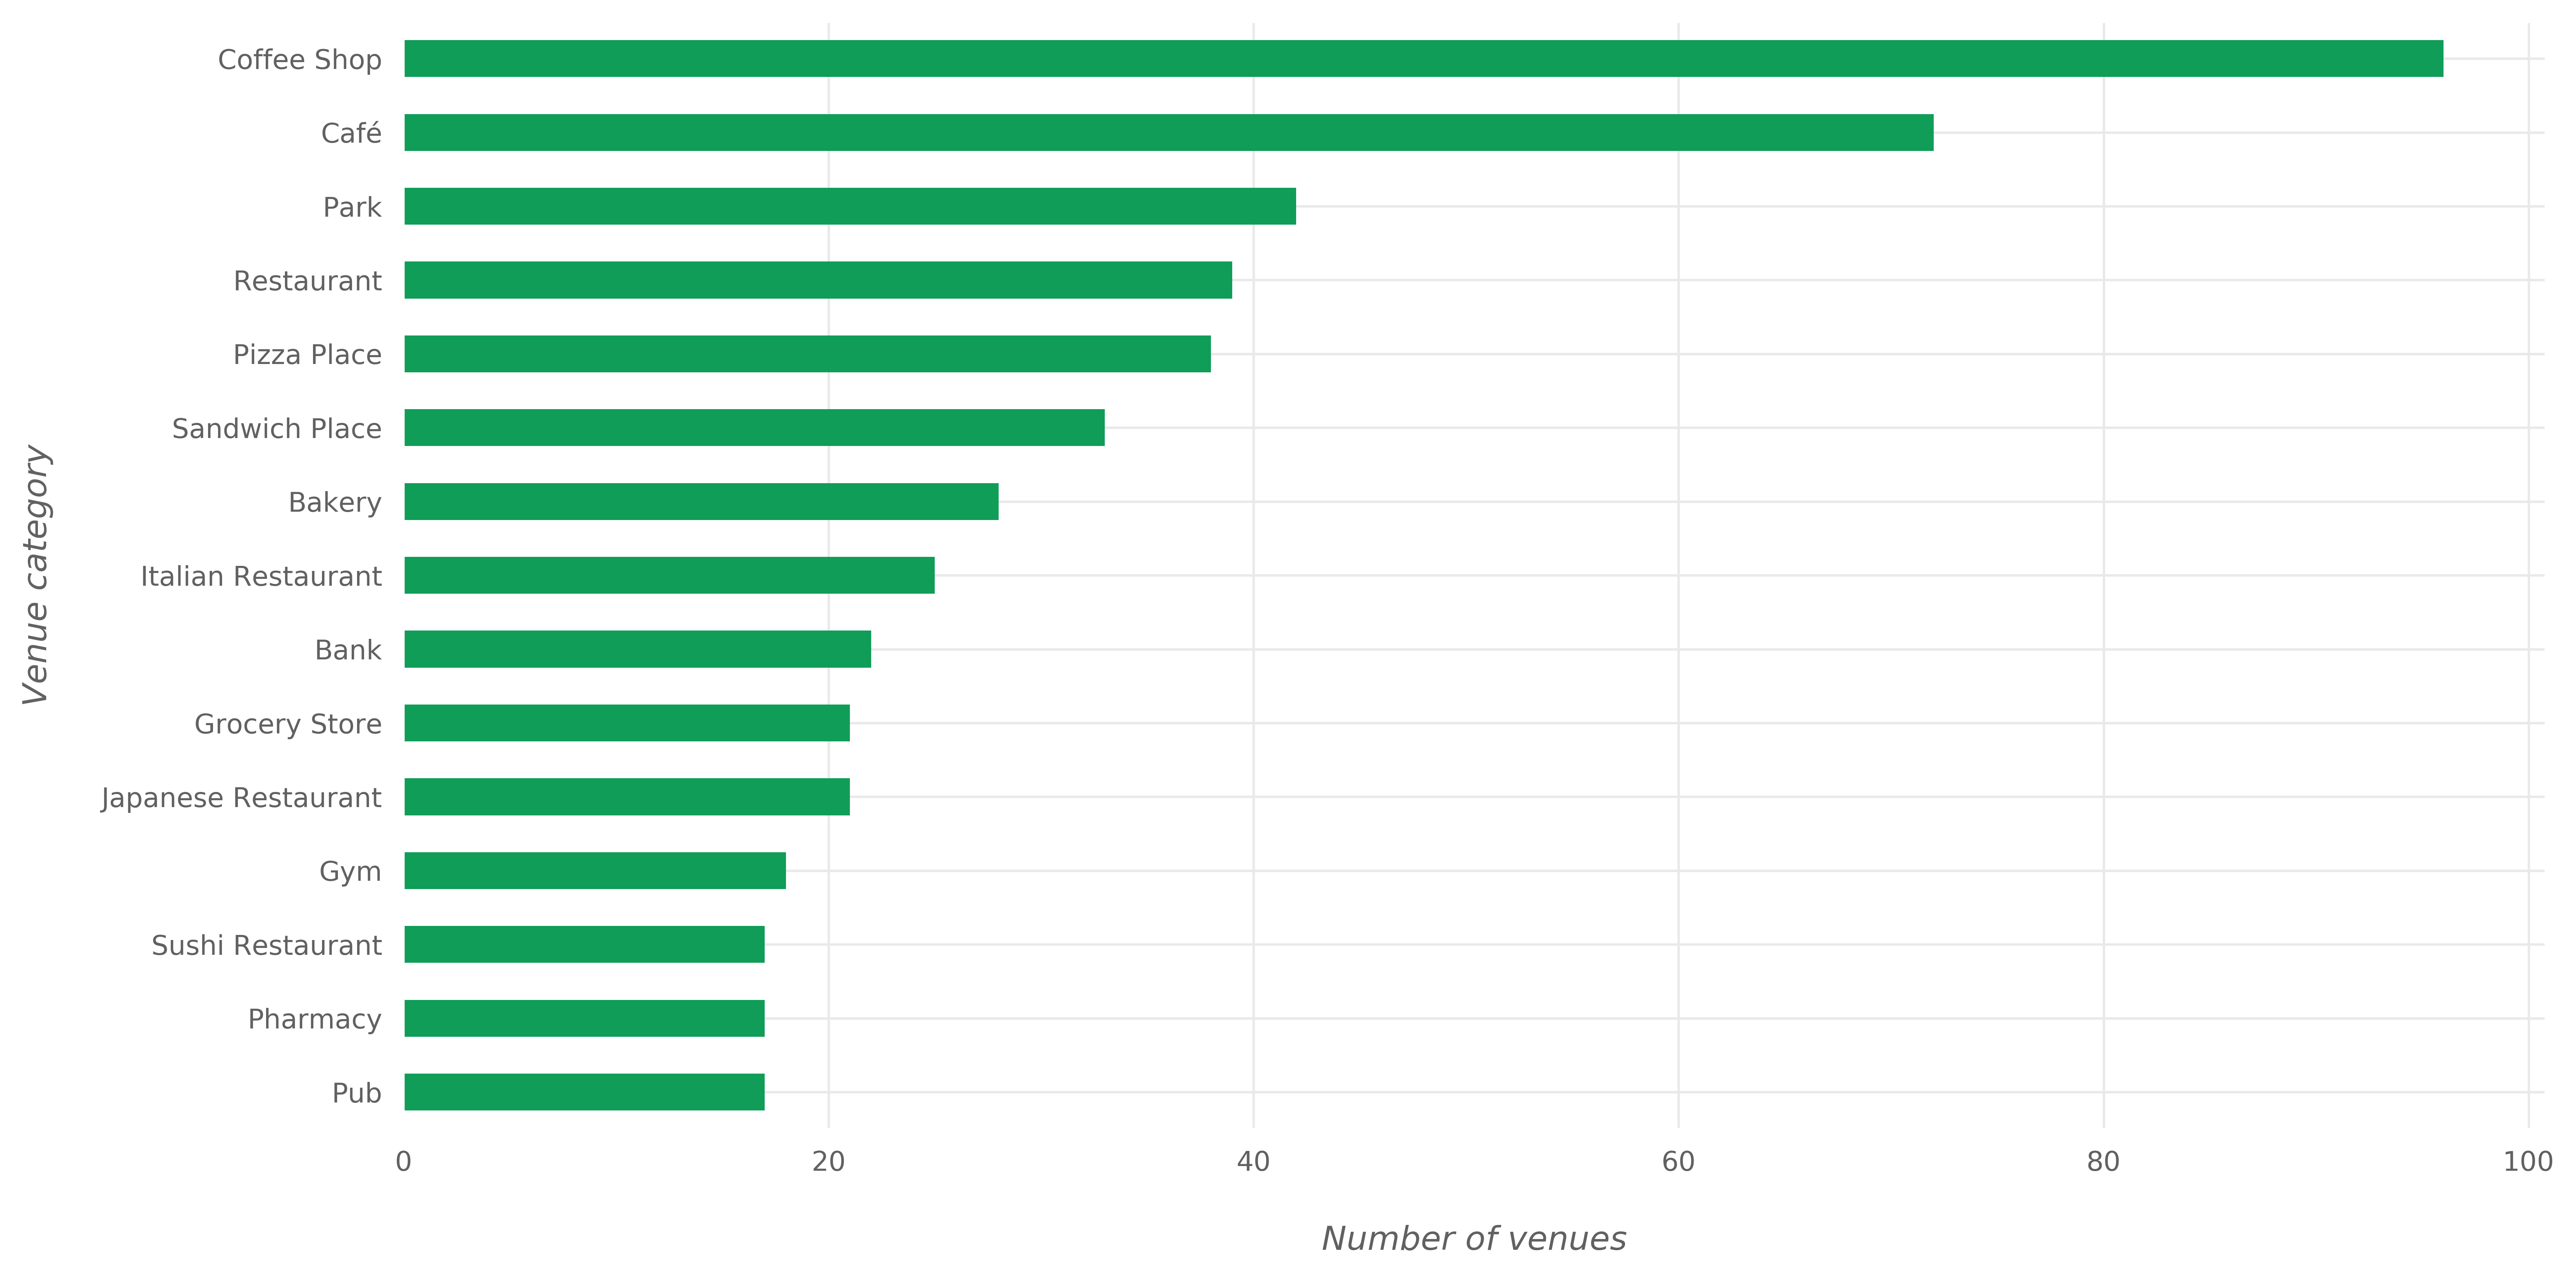

In [106]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

<h3>Most Common Venue Categories in Newyork City</h3>

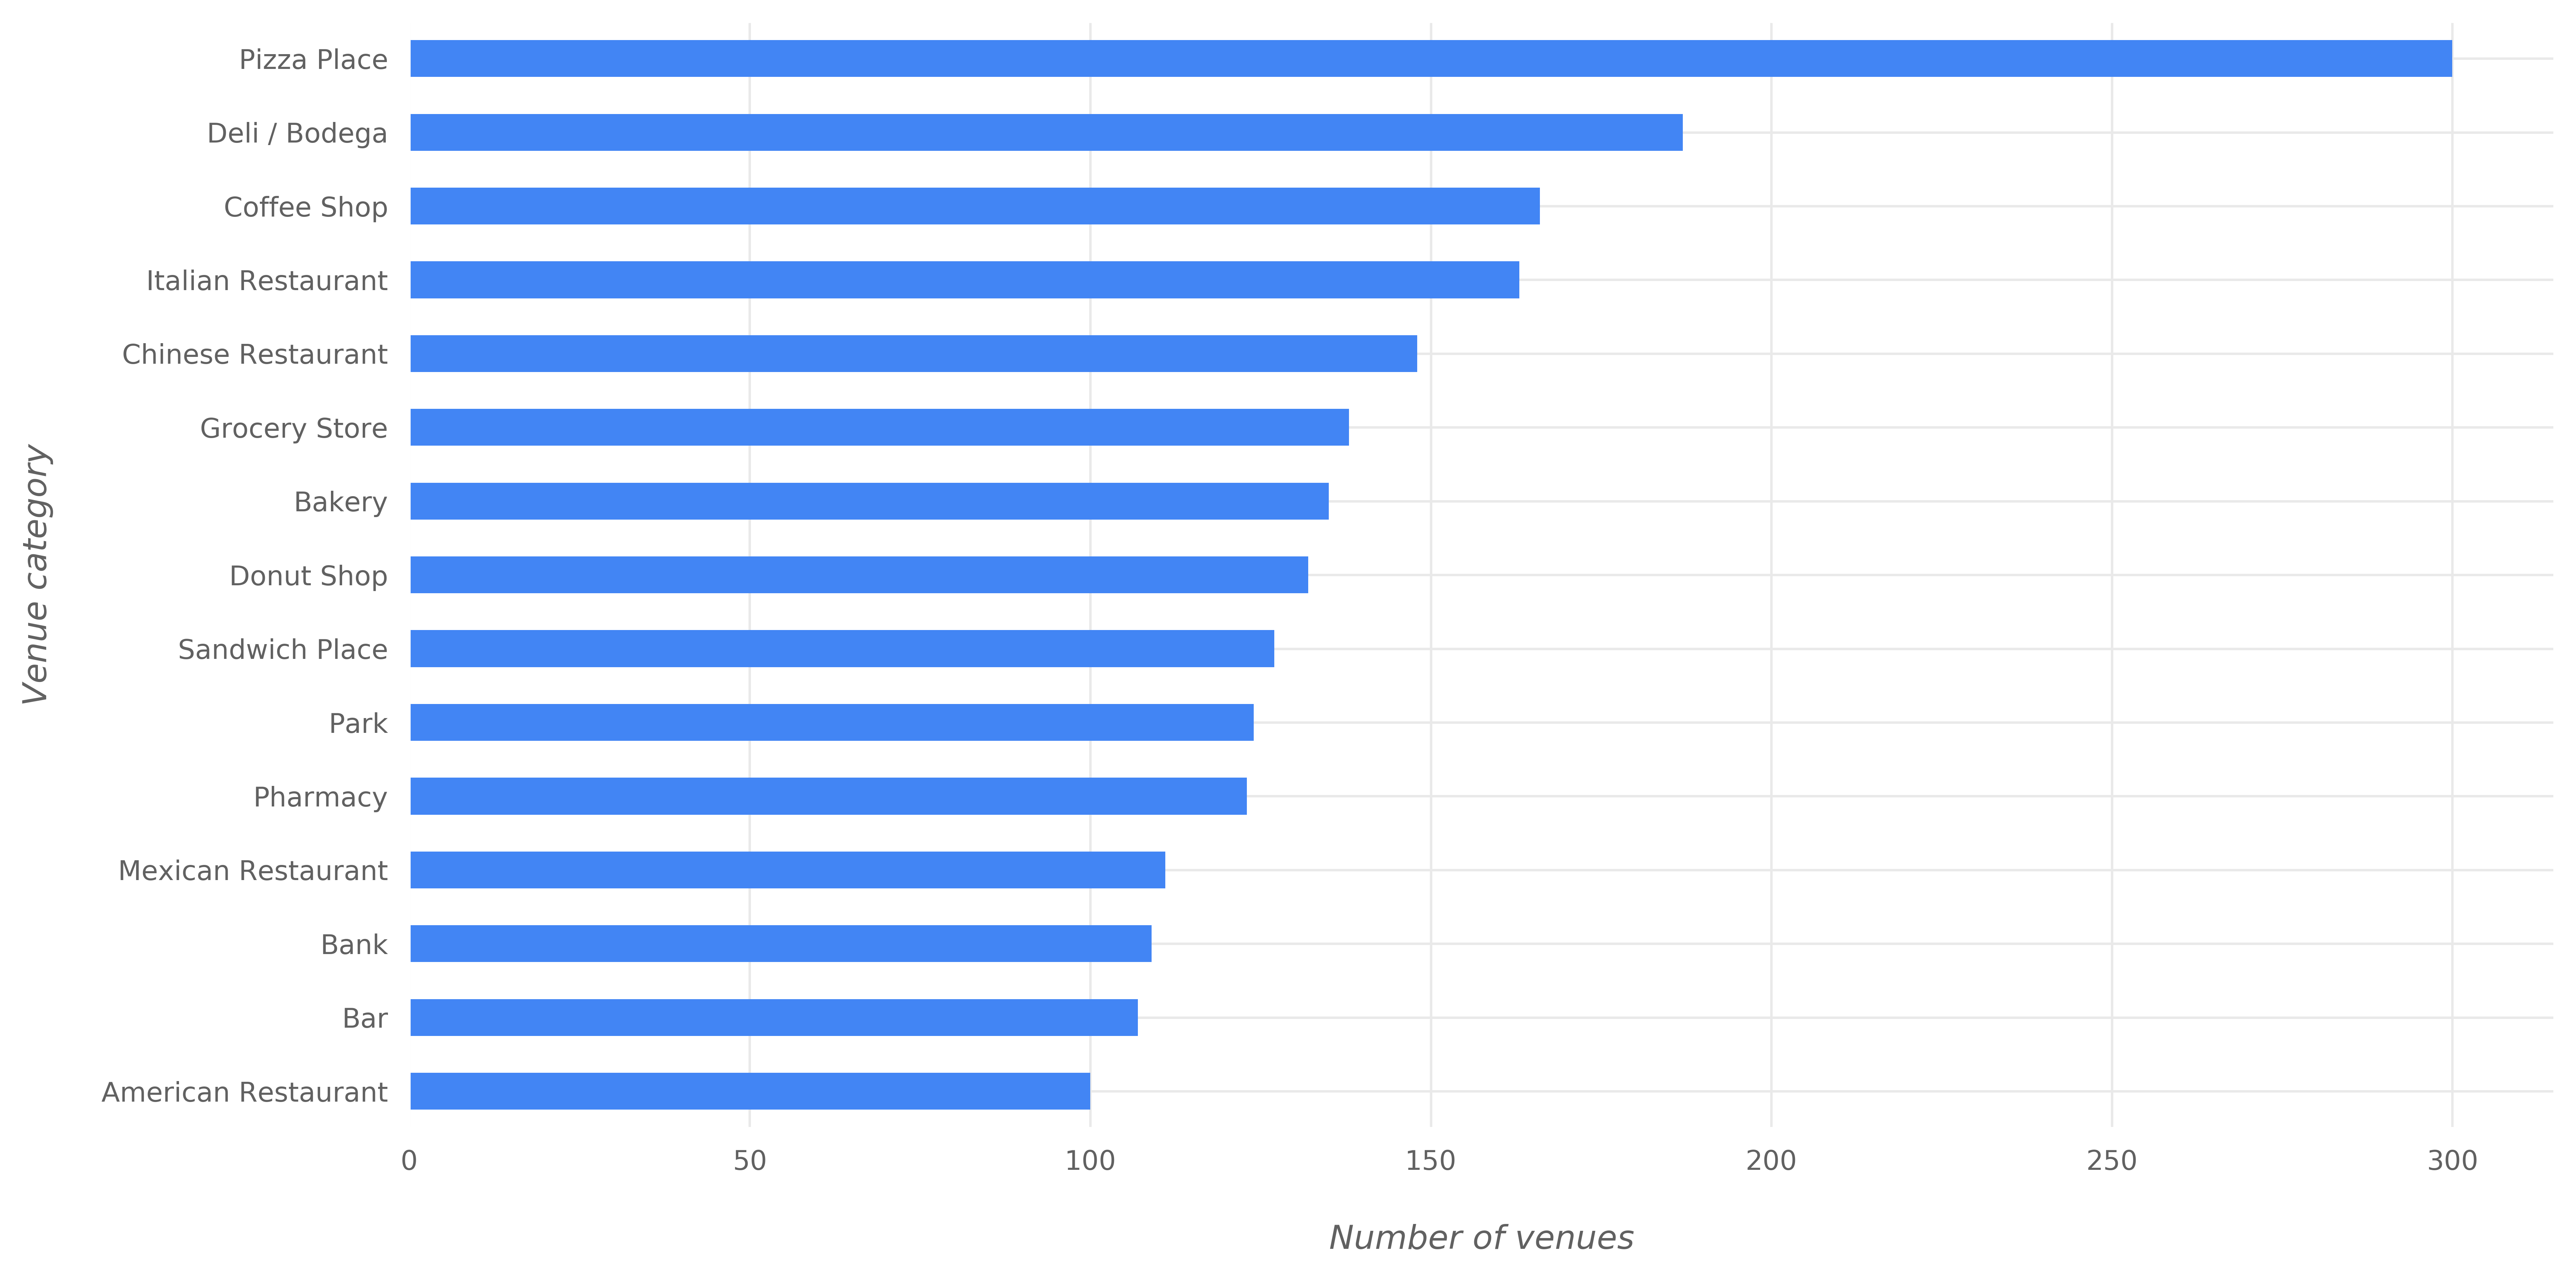

In [107]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

<h3>Which Venue Categories Exist More in Toronto Neighborhoods?</h3>

94 neighborhoods in Toronto


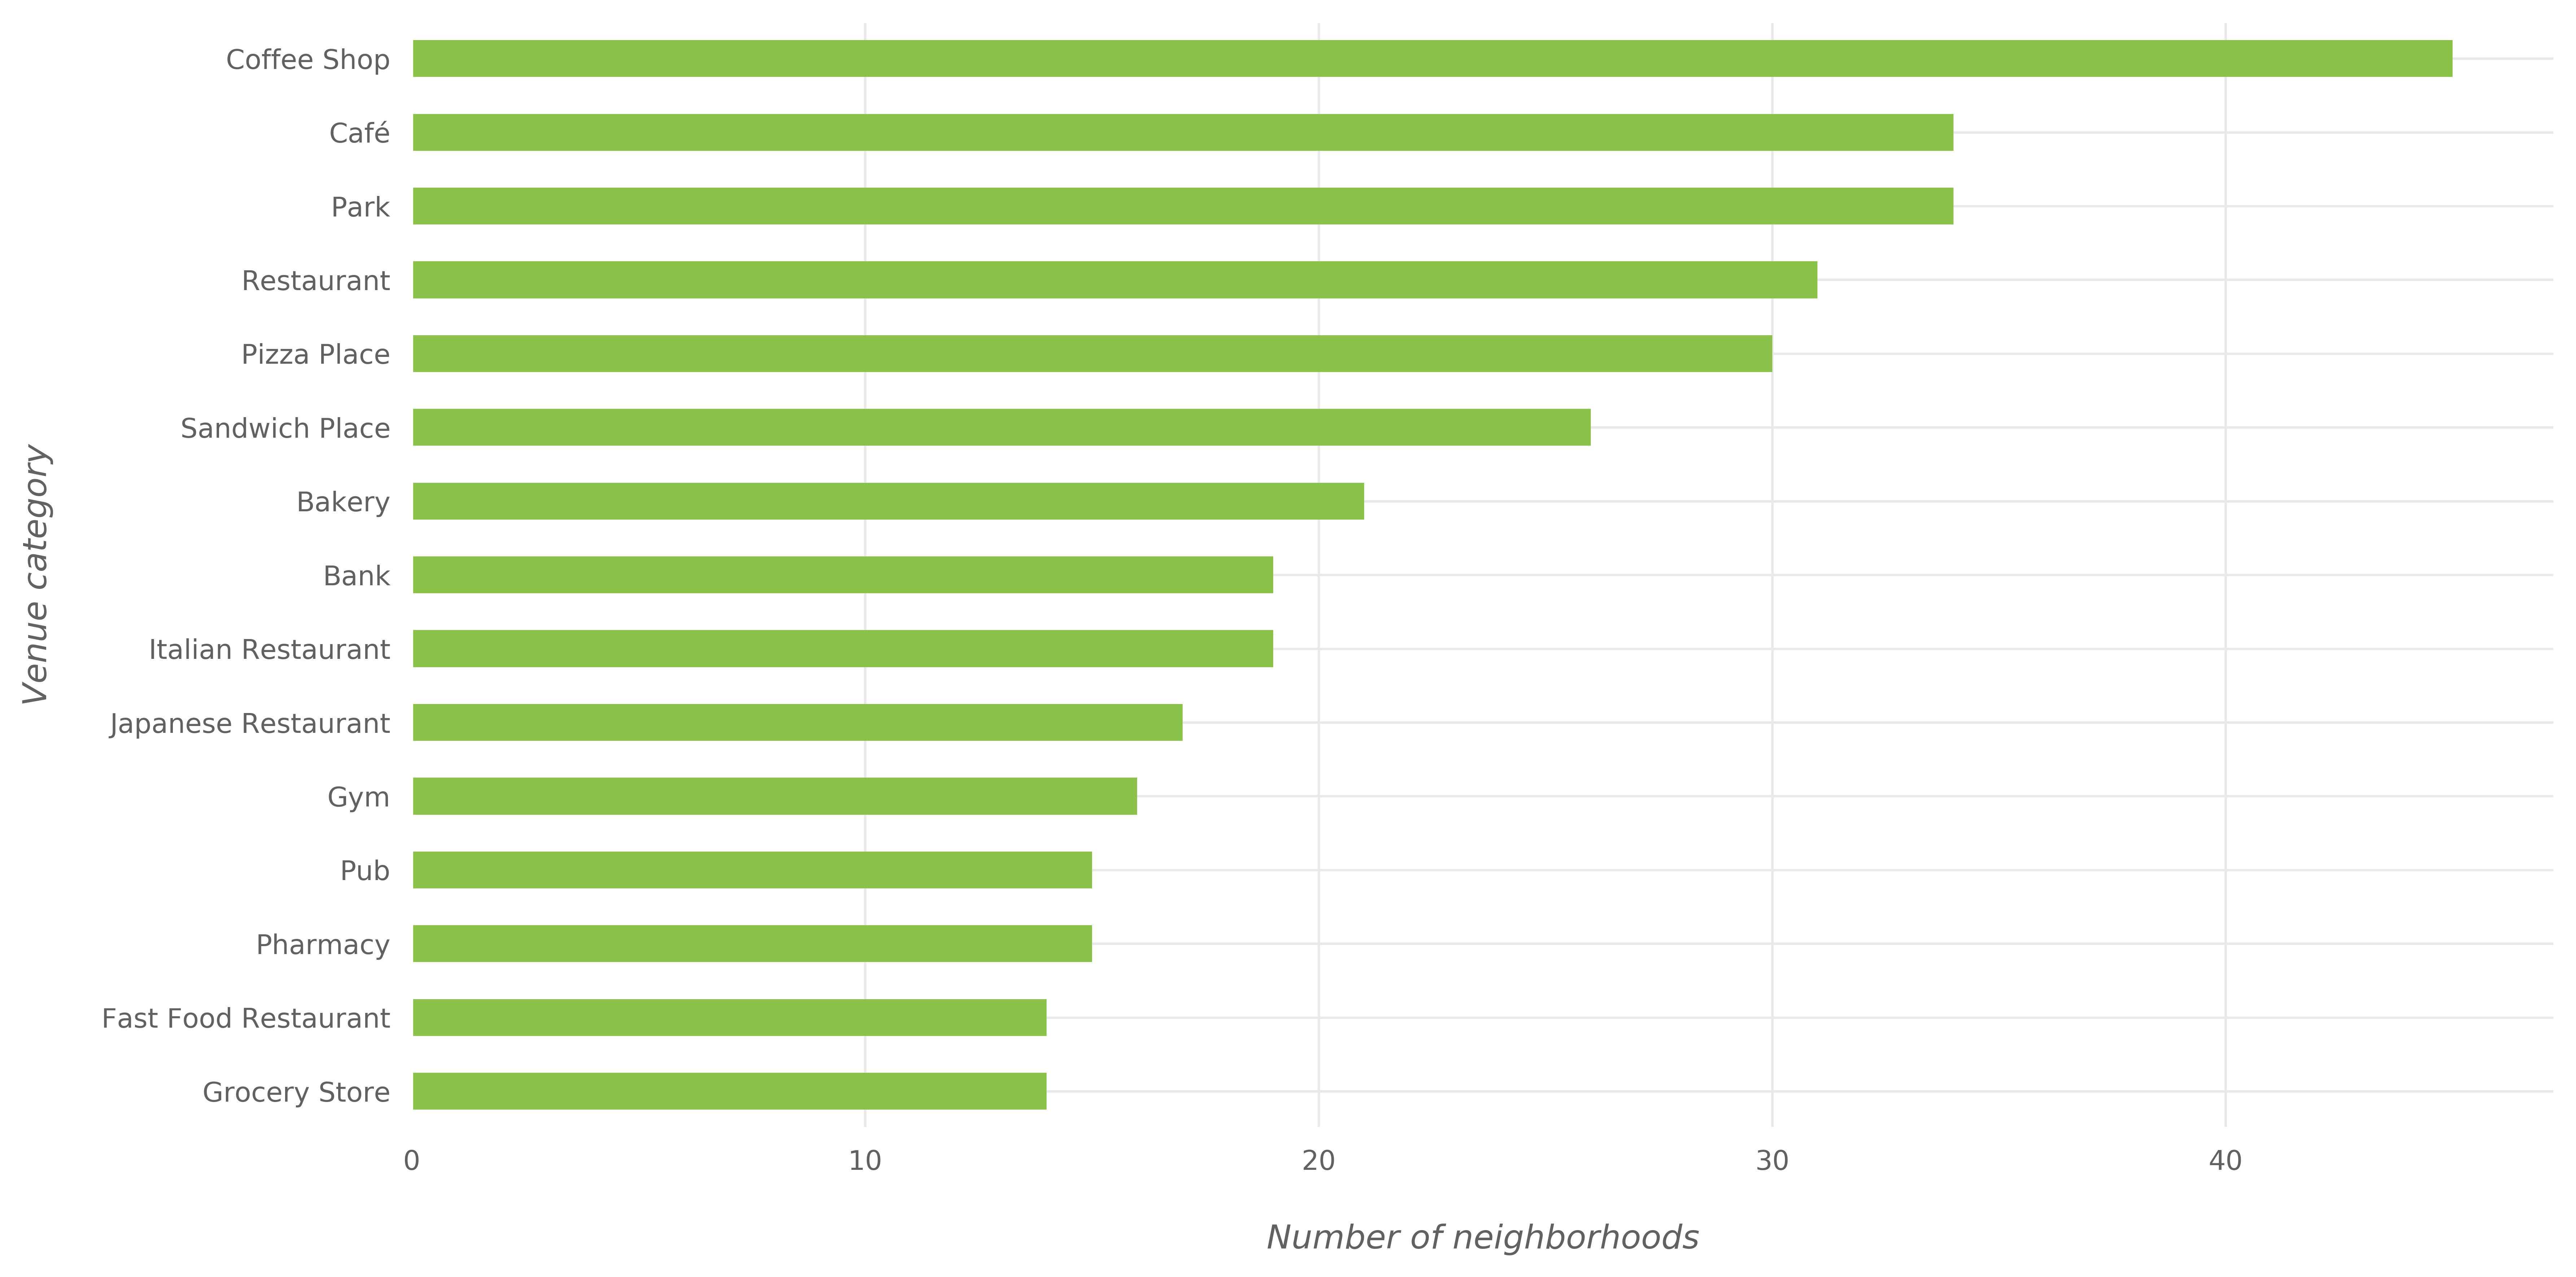

In [108]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

<h3>Which Venue Categories Exist More in Newyork Neighborhoods?</h3>

306 neighborhoods in NYC


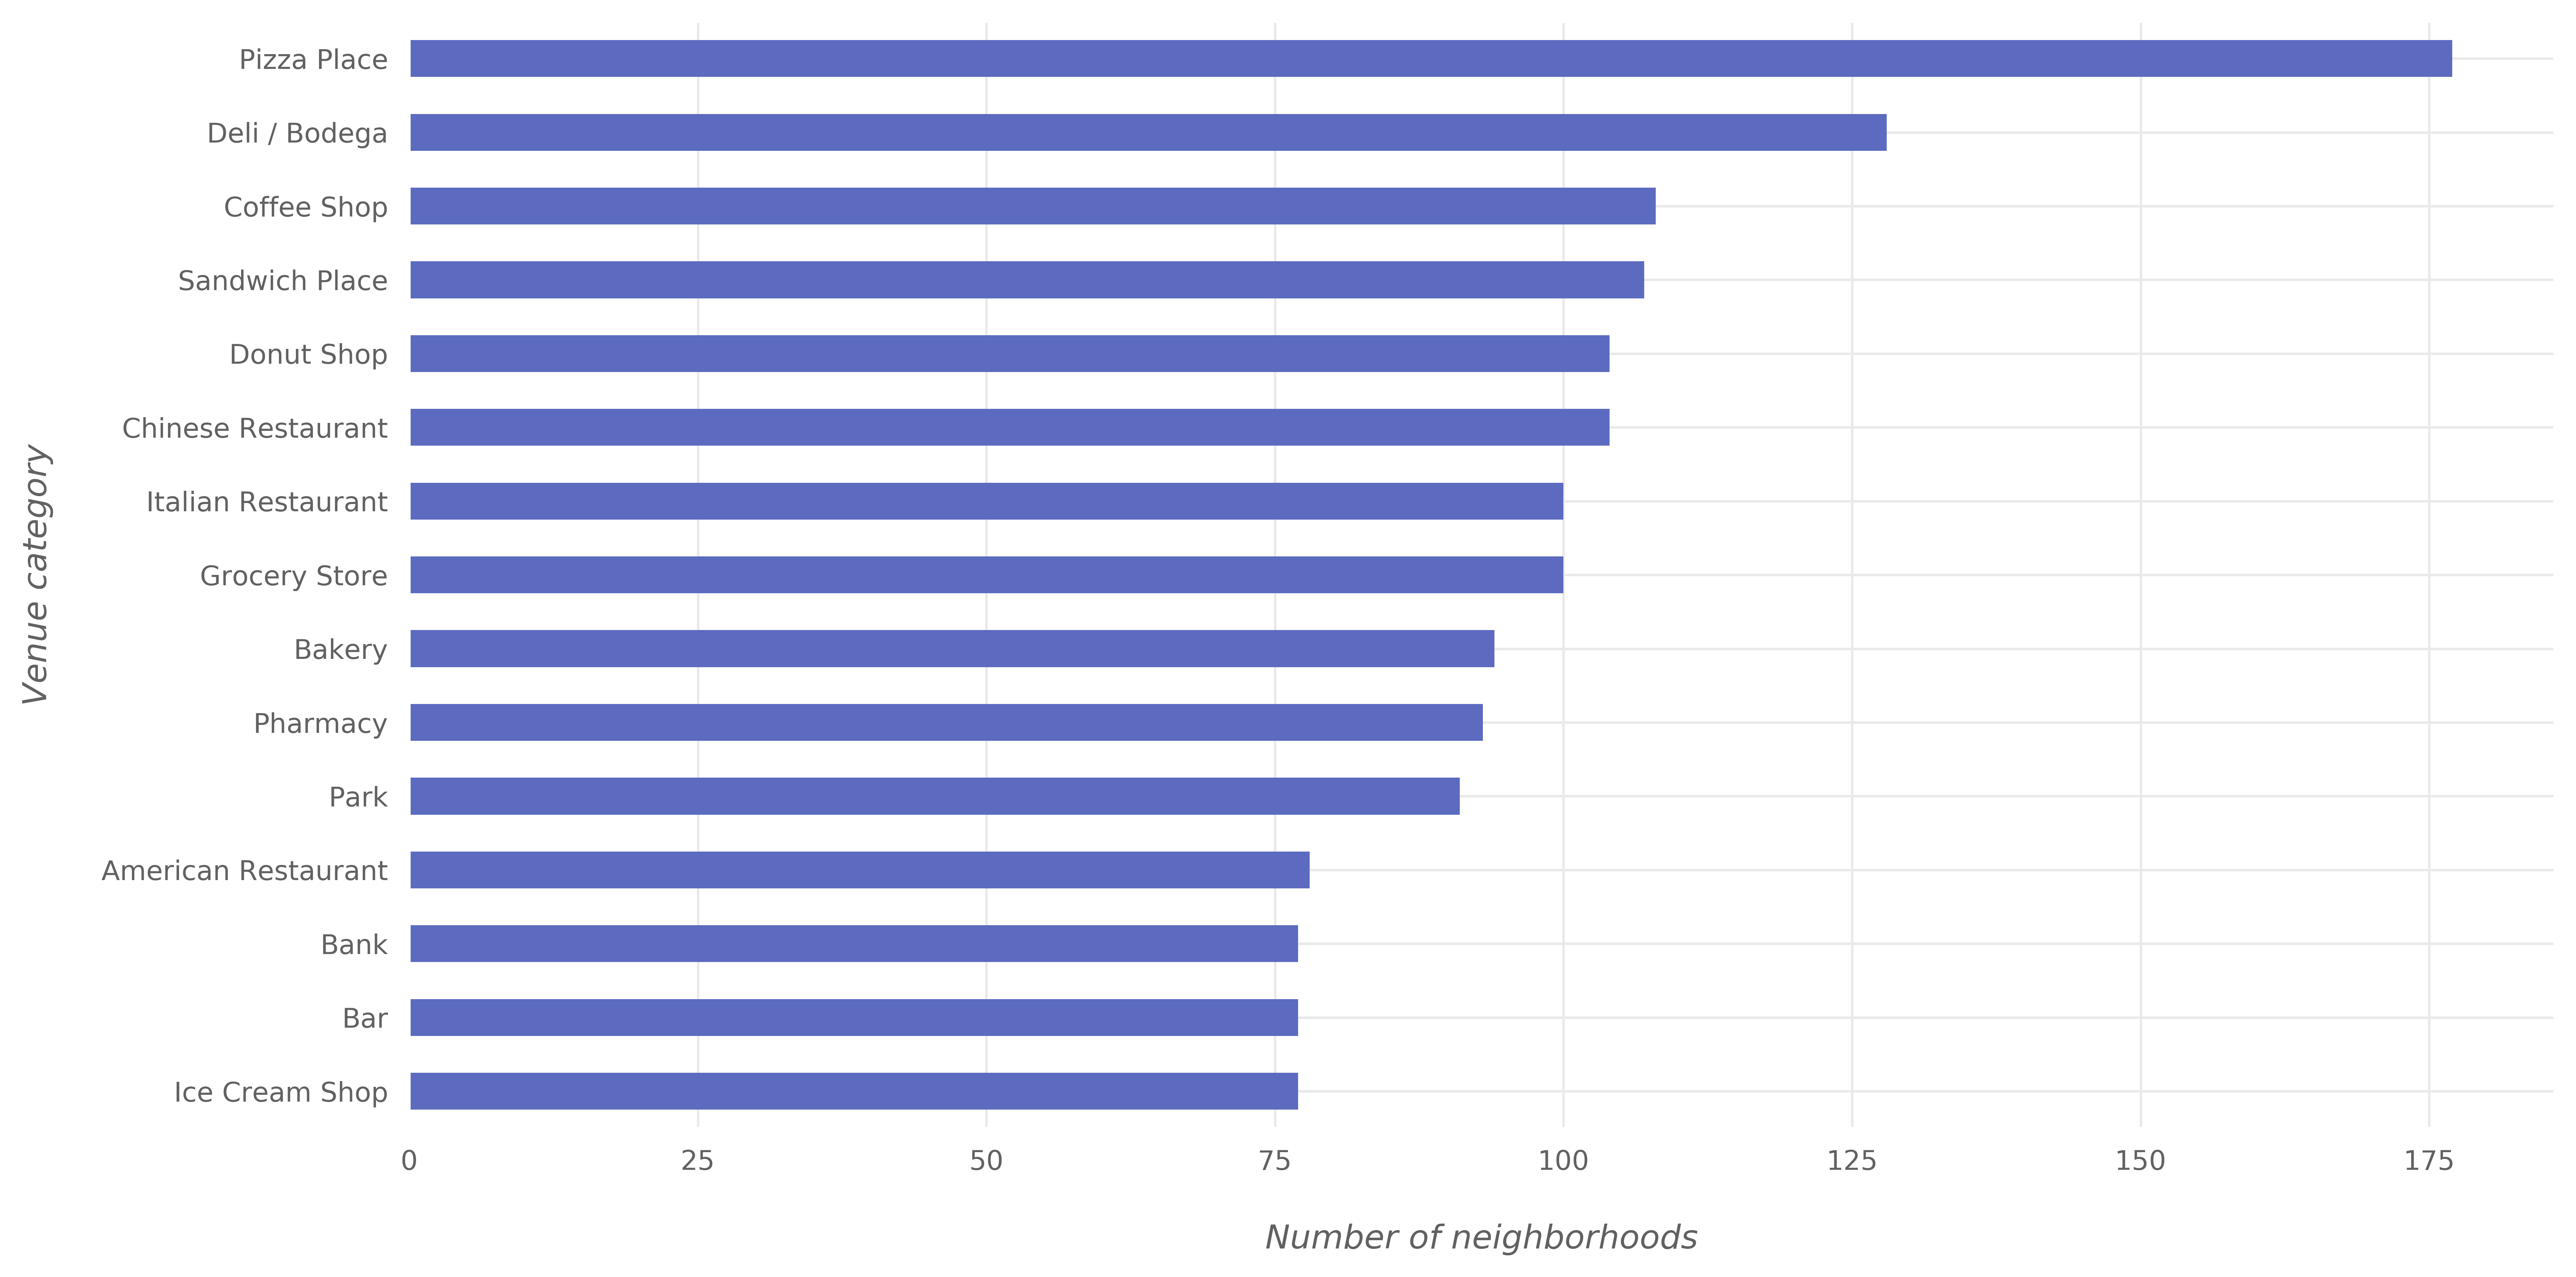

In [109]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = nyc_onehot.groupby('Neighborhood_').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

<h3>Rare Categories in Toronto</h3>

In [110]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

,Count
Venue Category,
Swim School,1
Supplement Shop,1
Drugstore,1
Belgian Restaurant,1
River,1
Food Court,1
College Gym,1
Stationery Store,1
Airport Gate,1


<h3>Rare Categories in Newyork</h3>

In [112]:
nyc_bot_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

,Count
Venue Category,
Physical Therapist,1
Medical Supply Store,1
Sri Lankan Restaurant,1
Poke Place,1
Auditorium,1
Tourist Information Center,1
Udon Restaurant,1
College Arts Building,1
Scandinavian Restaurant,1


<h3>Unique Columns in Toronto</h3>

In [114]:
clmns_tor_only = set(tor_grouped.columns).difference(set(nyc_grouped.columns))

<h3>Unique Columns in Newyork</h3>

In [115]:
clmns_nyc_only = set(nyc_grouped.columns).difference(set(tor_grouped.columns))

<h3>Concatenate both Toronto and Newyork data</h3>

In [116]:
tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')
nyc_grouped_ = nyc_grouped.copy()
nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)

tor_grouped_ = tor_grouped_[all_clmns_sorted]
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
    
tor_nyc_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [149]:
tor_nyc_grouped.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,BBQ Joint,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,IT Services,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repai

In [117]:
tor_nyc_grouped.shape

(400, 413)

<h3>Most Popular Venues in each Neighbourhood of both Cities</h3>

In [118]:
# obtaining the most popular categories for each neighborhood
tor_nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_nyc_neighborhoods_categories_sorted['Neighborhood_'] = tor_nyc_grouped['Neighborhood_']

for ind in np.arange(tor_nyc_grouped.shape[0]):
    tor_nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_nyc_grouped.iloc[ind, :], num_top_cat)

tor_nyc_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton_NYC,Pizza Place,Chinese Restaurant,Deli / Bodega,Supermarket,Spa,Bakery,Fried Chicken Joint,Electronics Store,Grocery Store,Gas Station
1,Annadale_NYC,Pizza Place,Pub,Cosmetics Shop,Park,Bakery,Sports Bar,Liquor Store,Diner,Dance Studio,Train Station
2,Arden Heights_NYC,Pizza Place,Pharmacy,Lawyer,Deli / Bodega,Coffee Shop,Yoga Studio,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
3,Arlington_NYC,Liquor Store,Deli / Bodega,Coffee Shop,American Restaurant,Yoga Studio,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
4,Arrochar_NYC,Deli / Bodega,Italian Restaurant,Athletics & Sports,Bagel Shop,Mediterranean Restaurant,Pizza Place,Supermarket,Sandwich Place,Liquor Store,Outdoors & Recreation


<h3>Rare Categories in both Toronto and Newyork Cities</h3>

In [119]:
nyc_tor_bot_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

,Count
Venue Category,
Summer Camp,1
Czech Restaurant,1
Aquarium,1
Curling Ice,1
Adult Boutique,1
Street Art,1
Used Bookstore,1
Bike Rental / Bike Share,1
Outlet Mall,1


<h2>Clustering on Grouped dataset having both Toronto and Newyork Neighbourhoods</h2>

In [120]:
# the number of clusters
kclusters = 5

tor_nyc_grouped_clustering = tor_nyc_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 2, 2, 0, 0, 1, 1, 1], dtype=int32)

In [121]:
# add clustering labels
tor_nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_nyc_merged = tor_nyc_neighborhoods_categories_sorted.set_index('Neighborhood_')

In [ ]:
tor_nyc_merged.head()

In [150]:
tor_nyc_merged.shape

(400, 11)

<h2>Examine Clusters</h2>

<h3>Cluster 1</h3>

In [130]:
C1=tor_nyc_merged.loc[tor_nyc_merged['Cluster Labels'] == 0,:]
print(C1.shape)
C1.head()

(198, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood_,,,,,,,,,,,
Arverne_NYC,0,Surf Spot,Metro Station,Sandwich Place,Bed & Breakfast,Donut Shop,Thai Restaurant,Wine Shop,Board Shop,Playground,Coffee Shop
Astoria_NYC,0,Seafood Restaurant,Gourmet Shop,Gym,Middle Eastern Restaurant,Ice Cream Shop,Dessert Shop,Indian Restaurant,Bagel Shop,Bakery,Greek Restaurant
Battery Park City_NYC,0,Park,Memorial Site,Food Court,Plaza,Steakhouse,BBQ Joint,Performing Arts Venue,Gym,Sandwich Place,Gourmet Shop
Bayside_NYC,0,Bakery,Indian Restaurant,Greek Restaurant,Bagel Shop,Asian Restaurant,Bistro,Mediterranean Restaurant,Sushi Restaurant,Latin American Restaurant,Gym
Bedford Stuyvesant_NYC,0,Deli / Bodega,Café,Bar,Pizza Place,Coffee Shop,Fried Chicken Joint,BBQ Joint,Gourmet Shop,Gift Shop,Bagel Shop


<h3>Cluster 2</h3>

In [131]:
C2=tor_nyc_merged.loc[tor_nyc_merged['Cluster Labels'] == 1,:]
print(C2.shape)
C2.head()

(159, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood_,,,,,,,,,,,
Allerton_NYC,1,Pizza Place,Chinese Restaurant,Deli / Bodega,Supermarket,Spa,Bakery,Fried Chicken Joint,Electronics Store,Grocery Store,Gas Station
Annadale_NYC,1,Pizza Place,Pub,Cosmetics Shop,Park,Bakery,Sports Bar,Liquor Store,Diner,Dance Studio,Train Station
Astoria Heights_NYC,1,Plaza,Chinese Restaurant,Bowling Alley,Bakery,Motel,Hostel,Supermarket,Italian Restaurant,Playground,Liquor Store
Auburndale_NYC,1,Supermarket,Miscellaneous Shop,Toy / Game Store,Pet Store,Athletics & Sports,Train,Korean Restaurant,Pharmacy,Sushi Restaurant,Furniture / Home Store
Bath Beach_NYC,1,Pharmacy,Bubble Tea Shop,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Bakery,Gas Station,Bank,Cantonese Restaurant,Park


<h3>Cluster 3</h3>

In [132]:
C3=tor_nyc_merged.loc[tor_nyc_merged['Cluster Labels'] == 2,:]
print(C3.shape)
C3.head()

(32, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood_,,,,,,,,,,,
Arden Heights_NYC,2,Pizza Place,Pharmacy,Lawyer,Deli / Bodega,Coffee Shop,Yoga Studio,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
Arlington_NYC,2,Liquor Store,Deli / Bodega,Coffee Shop,American Restaurant,Yoga Studio,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
Arrochar_NYC,2,Deli / Bodega,Italian Restaurant,Athletics & Sports,Bagel Shop,Mediterranean Restaurant,Pizza Place,Supermarket,Sandwich Place,Liquor Store,Outdoors & Recreation
Belle Harbor_NYC,2,Beach,Deli / Bodega,Pub,Spa,Bagel Shop,Mexican Restaurant,Chinese Restaurant,Pharmacy,Donut Shop,Italian Restaurant
Belmont_NYC,2,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Food & Drink Shop,Mexican Restaurant,Fish Market,Market,Liquor Store


<h3>Cluster 4</h3>

In [133]:
C4=tor_nyc_merged.loc[tor_nyc_merged['Cluster Labels'] == 3,:]
print(C4.shape)
C4.head()

(9, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood_,,,,,,,,,,,
Bayswater_NYC,3,Park,Tennis Court,Playground,Factory,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
Clason Point_NYC,3,Park,Grocery Store,Boat or Ferry,Pool,Business Service,South American Restaurant,Yoga Studio,Factory,Electronics Store,Empanada Restaurant
Somerville_NYC,3,Park,Yoga Studio,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
Todt Hill_NYC,3,Park,Yoga Studio,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
Caledonia-Fairbanks_Toronto,3,Park,Women's Store,Pool,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service


<h3>Cluster 5</h3>

In [134]:
C5=tor_nyc_merged.loc[tor_nyc_merged['Cluster Labels'] == 4,:]
print(C5.shape)
C5.head()

(2, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood_,,,,,,,,,,,
"Humberlea, Emery_Toronto",4,Furniture / Home Store,Baseball Field,Yoga Studio,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East_Toronto",4,Baseball Field,Yoga Studio,French Restaurant,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit


In [137]:
clust_cats = []
clusters = [C1, C2, C3, C4, C5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(nyc_venues[nyc_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

#clust_cats[0]

In [138]:
tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [145]:
from IPython.display import HTML

for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

,% of venues
Category,
Coffee Shop,5.213632
Café,3.357070
Park,2.594100
Italian Restaurant,2.466938
Bakery,2.187182
Pizza Place,2.187182
Bar,2.161750


,% of venues
Category,
Pizza Place,7.676835
Pharmacy,3.955749
Chinese Restaurant,3.788133
Donut Shop,3.553470
Bank,3.519946
Grocery Store,3.519946
Sandwich Place,3.285283


,% of venues
Category,
Deli / Bodega,17.500000
Italian Restaurant,7.222222
Pizza Place,6.388889
Donut Shop,2.500000
Bakery,2.500000
Hotel,2.222222
Beach,2.222222


,% of venues
Category,
Park,53.571429
Playground,10.714286
Pool,7.142857
Business Service,3.571429
South American Restaurant,3.571429
Boat or Ferry,3.571429
Grocery Store,3.571429


,% of venues
Category,
Baseball Field,66.666667
Furniture / Home Store,33.333333


In [141]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

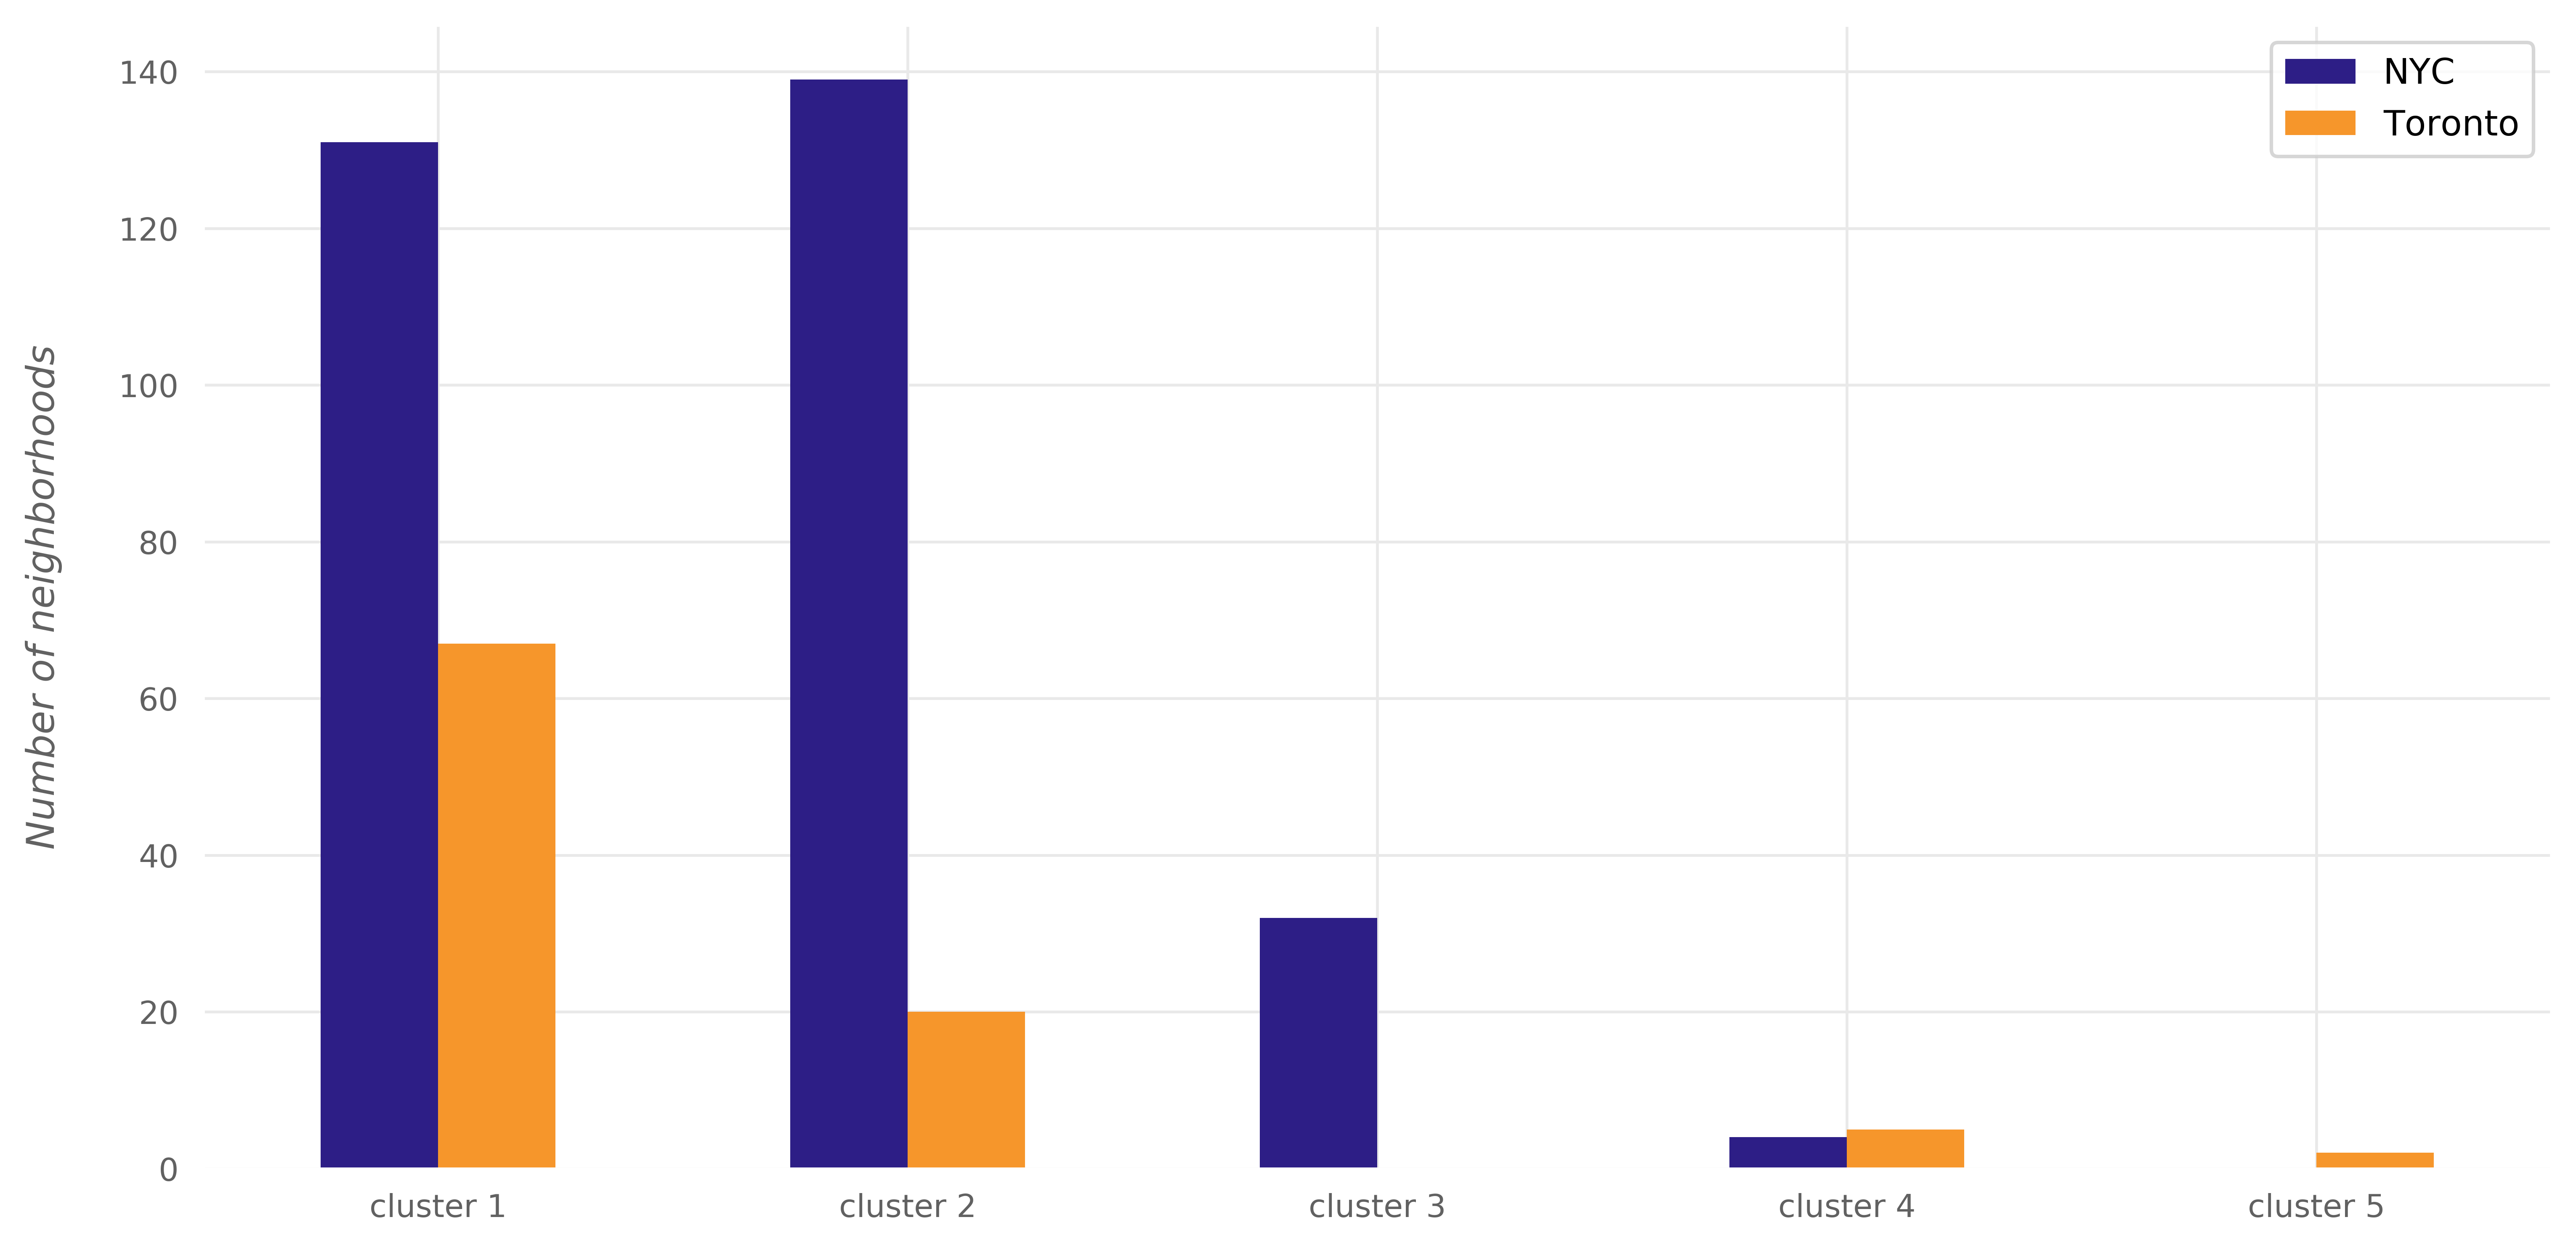

In [142]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NYC': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)